# Import libraries

In [1]:
import pathlib
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
# from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Read data from file

In [6]:
df = pd.read_csv('../data/raw/data.csv',parse_dates=True)

# Looking into data

In [14]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2020-12-22 09:15:00+05:30,13373.650391,13446.599609,13193.900391,13301.400391,0,0.0,0.0
2020-12-22 10:15:00+05:30,13253.349609,13345.549805,13248.299805,13262.099609,0,0.0,0.0
2020-12-22 11:15:00+05:30,13279.200195,13296.700195,13208.650391,13241.599609,0,0.0,0.0
2020-12-22 12:15:00+05:30,13260.450195,13297.150391,13196.750000,13278.599609,0,0.0,0.0
2020-12-22 13:15:00+05:30,13270.549805,13428.799805,13263.299805,13428.750000,0,0.0,0.0


In [6]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,3453.000000,3453.000000,3453.000000,3453.000000,3453.0,3453.0,3453.0
mean,16574.934352,16606.478797,16538.389794,16573.775234,0.0,0.0,0.0
std,1273.522260,1271.498963,1275.965276,1273.279596,0.0,0.0,0.0
min,13253.349609,13296.700195,13193.900391,13241.599609,0.0,0.0,0.0
25%,15696.700195,15719.450195,15662.599609,15692.950195,0.0,0.0,0.0
50%,16879.099609,16922.050781,16848.400391,16881.849609,0.0,0.0,0.0
75%,17603.550781,17635.400391,17567.150391,17604.650391,0.0,0.0,0.0
max,18871.949219,18886.699219,18832.449219,18844.150391,0.0,0.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3453 entries, 2020-12-22 09:15:00+05:30 to 2022-12-21 15:15:00+05:30
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3453 non-null   float64
 1   High          3453 non-null   float64
 2   Low           3453 non-null   float64
 3   Close         3453 non-null   float64
 4   Volume        3453 non-null   int64  
 5   Dividends     3453 non-null   float64
 6   Stock Splits  3453 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 215.8 KB


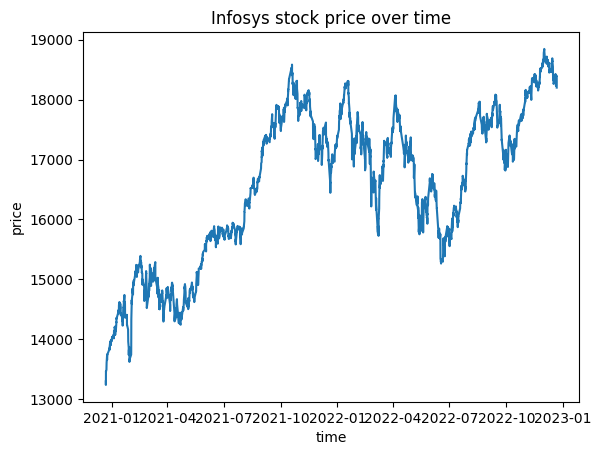

In [8]:
plt.plot(df.index, df["Close"])
plt.title("Infosys stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

# Find p, d, and q values for ARIMA model 

Before building the ARIMA model, let’s see if there is some cross-correlation in out data.

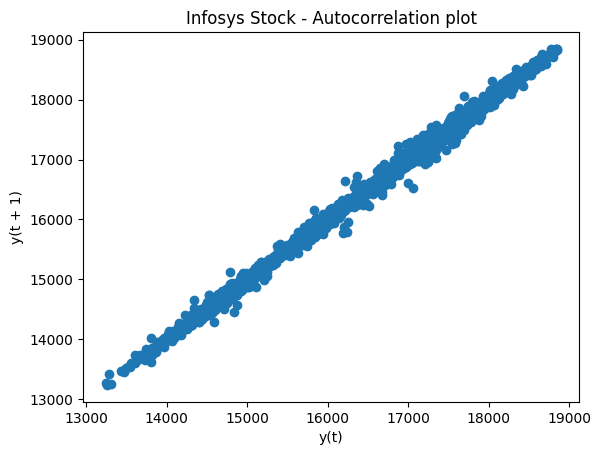

In [9]:
lag_plot(df['Close'], lag=1)
plt.title('Infosys Stock - Autocorrelation plot')
plt.show()

p is order of Autoregrassion <br>
d is order of differencing requiredd to make time series stationary <br>
q is order Moving aaverages

## Stationarity

Substract current value from previous value. We need to do diffenting peration multiple times to make series stationary. <br>
Select minimun value for ARIMA model.

### ADF test

We will use Augumented Dickey Fuller (ADF) test check stationarity in series. <br>
<br>
Null hypothesis of ADF test is that time series is non-stationary. If p-value of test is less than 0.05 then wee can reject null hypothesis. <br>
So, if p-value > 0.05 we'll find order of diffencing.  

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
dftest = adfuller(df['Close'],autolag='AIC')
print('1. ADF statistic :',dftest[0])
print('2. P-value :',dftest[1])

1. ADF statistic : -2.306267144836813
2. P-value : 0.16995465895620965


## ## We find our series is non-stationary.

In [12]:
# from pmdarima import auto_arima
# import warnings
# warnings.filterwarnings('ignore')

## Autocorrelation Function (ACF) Plot

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

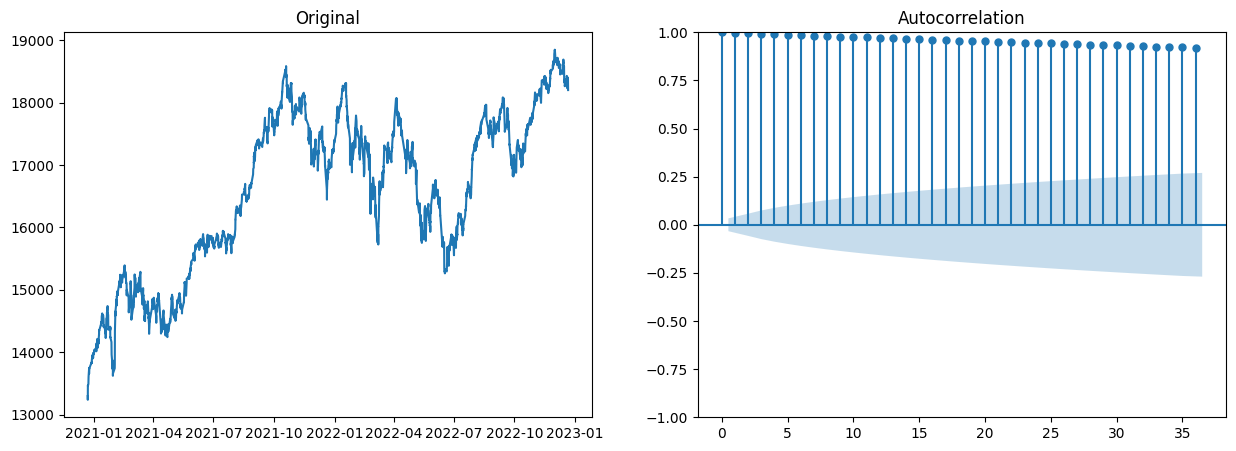

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(df['Close'])
ax1.set_title('Original')
plot_acf(df['Close'], ax=ax2);

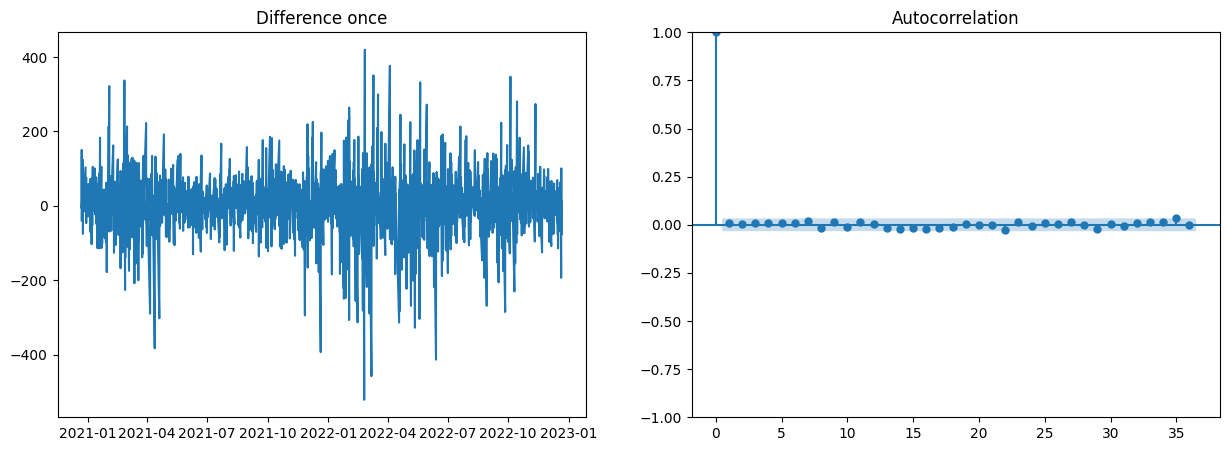

In [15]:
diff = df['Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_acf(diff, ax=ax2);

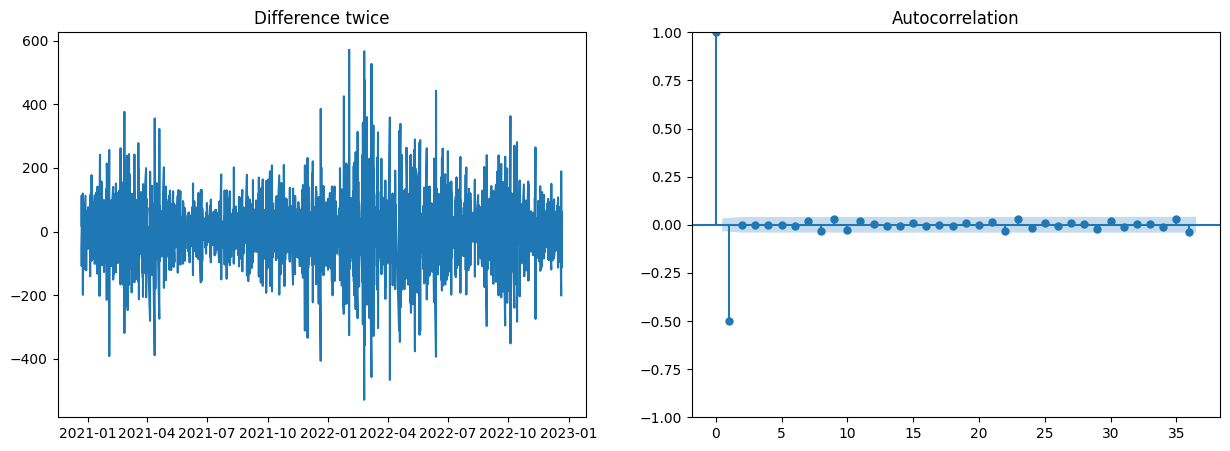

In [16]:
diff = df['Close'].diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference twice')
plot_acf(diff, ax=ax2);

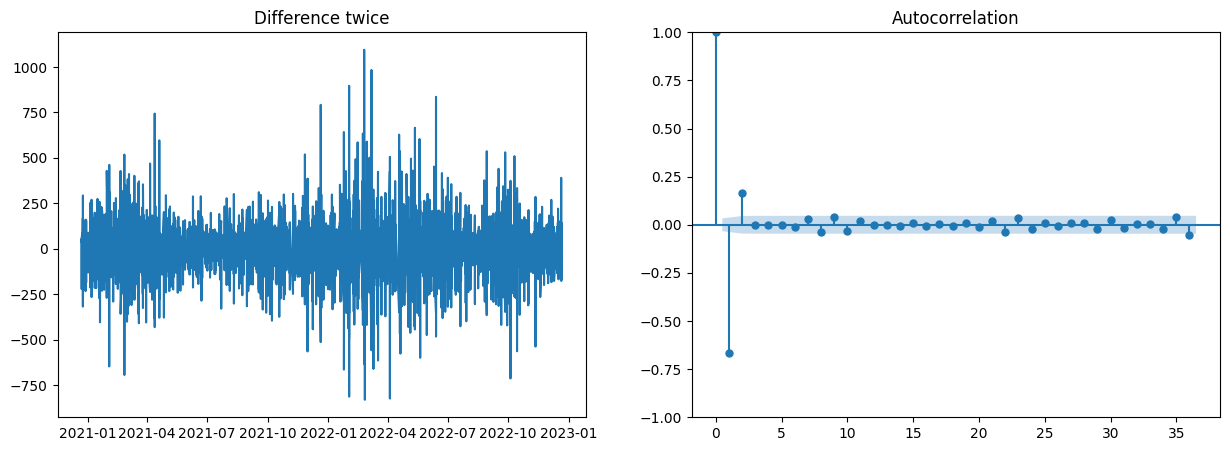

In [17]:
diff = df['Close'].diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference twice')
plot_acf(diff, ax=ax2);

## ## Here we find diffence order 3 is good.

Because there is gives positive value in third order differencing.

# p

p is the order of Auto regression (AR). It refers to number of lags to be used ass predictors. <br>
We can find required number of AR terms by inspecting Partial Autocorrelation (PACF) plot. <br>
The Partial Autocorrelation represents correlation between series and it's lags.

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf

/home/rohit/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


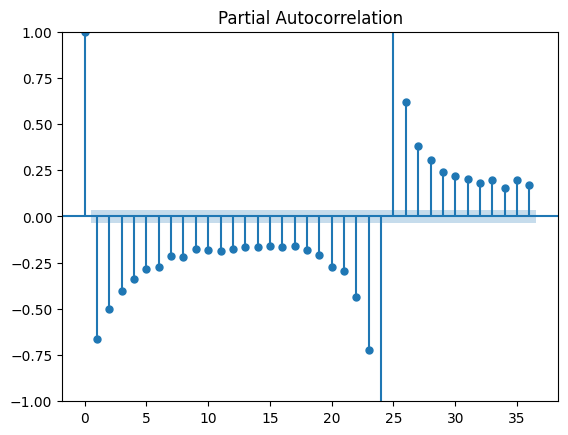

In [19]:
diff = df['Close'].diff().diff().diff().dropna()

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# ax1.plot(diff)
# ax1.set_title('Difference once')
p = plot_pacf(diff);

In [20]:
# statsmodels.tsa.stattools.pacf
from statsmodels.tsa.stattools import pacf
diff = df['Close'].diff().diff().diff().dropna()
print(pacf(diff))

[ 1.         -0.66516283 -0.50007001 -0.40212428 -0.33605764 -0.28310612
 -0.27386284 -0.21213129 -0.2167459  -0.17669005 -0.18208629 -0.18539022
 -0.17740232 -0.16248421 -0.16756221 -0.16171178 -0.16458499 -0.15940226
 -0.18184402 -0.2061629  -0.27136549 -0.29569836 -0.43447585 -0.72283398
 -2.58201912  1.62066568  0.61762737  0.38090831  0.30634888  0.24046817
  0.21806601  0.20208428  0.18221212  0.19570133  0.15406666  0.1983958 ]


In [21]:
from statsmodels.tsa.stattools import acf
diff = df['Close'].diff().diff().diff().dropna()
print(acf(diff))

[ 1.00000000e+00 -6.64970027e-01  1.63528492e-01  1.22491103e-03
  7.39013766e-04  1.32168199e-03 -1.11348832e-02  2.78375781e-02
 -3.91143023e-02  3.83546476e-02 -3.26175098e-02  2.06189228e-02
 -3.16208335e-03 -2.44311444e-03 -4.64329699e-03  8.81051412e-03
 -6.28384358e-03  3.75521014e-03 -6.85111121e-03  8.83590267e-03
 -9.07406151e-03  2.13977629e-02 -3.77969855e-02  3.71876544e-02
 -2.33677041e-02  1.18107744e-02 -8.85874329e-03  7.15735484e-03
  6.97148158e-03 -2.38157063e-02  2.54579449e-02 -1.65038388e-02
  5.50625162e-03  5.86487032e-03 -2.07257486e-02  3.88857467e-02]


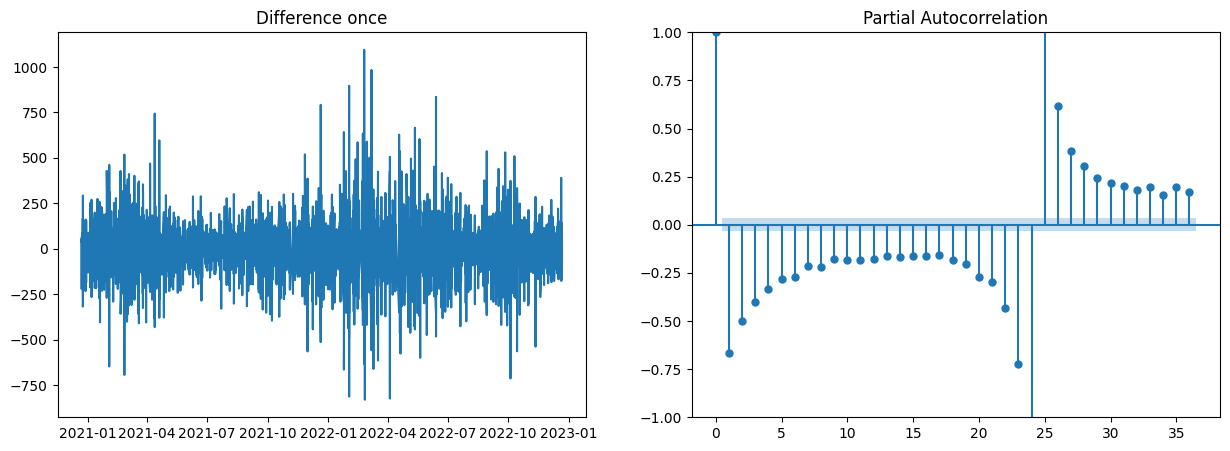

In [22]:
diff = df['Close'].diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_pacf(diff, ax=ax2);

## ## 20 is the positive value for Auto regression

# q

q is the order of moving average (MA). It refers to number of laged forecast erros that should be go into the ARIMA. <br>
We can look at ACF plot for number of MA term.

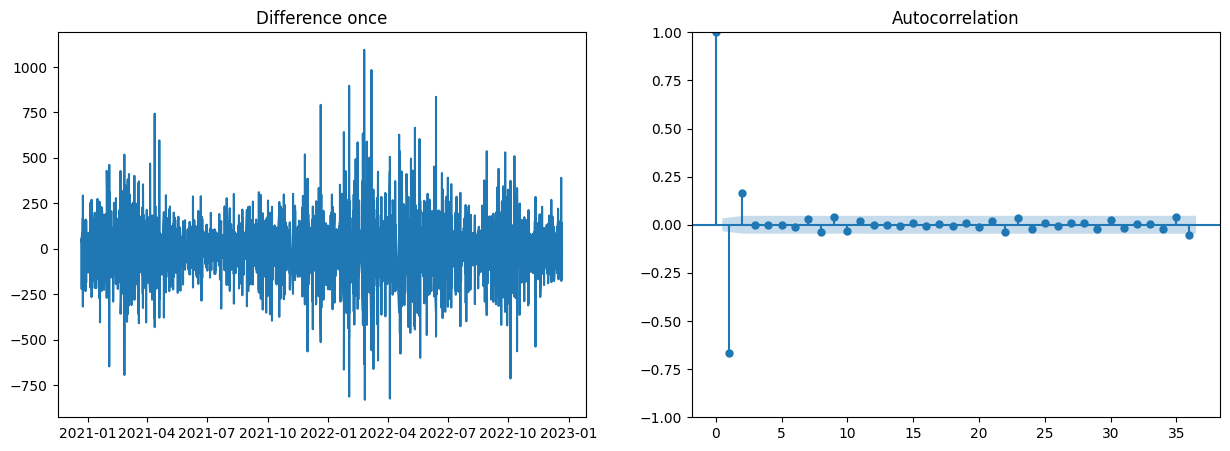

In [23]:
diff = df['Close'].diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_acf(diff, ax=ax2);

## ## We find that 2 is no order for MA

In [24]:
# stepswise_fit = auto_arima(df['Close'], trace=True, suppress_warnings=True)
# stepswise_fit.summary()

# Let's build model

In [25]:
# train_data, test_data = df[0:int(len(df)*0.9)], df[int(len(df)*0.9):]

# training_data = train_data['Close'].values
# test_data = test_data['Close'].values

# history = [x for x in training_data]
# model_predictions = []
# N_test_observations = len(test_data)

# residuals = 0

# for time_point in range(N_test_observations):
#     model = ARIMA(history, order=(20,3,2))
#     model_fit = model.fit()
#     output = model_fit.forecast()
#     yhat = output[0]
#     model_predictions.append(yhat)
#     true_test_value = test_data[time_point]
#     history.append(true_test_value)

#     residuals = pd.DataFrame(model_fit.resid)
    
# MSE_error = mean_squared_error(test_data, model_predictions)
# print('Testing Mean Squared Error is {}'.format(MSE_error))

In [26]:
# residuals = residuals[1:]

In [27]:
# fig, ax = plt.subplots(1,2)
# residuals.plot(title="Residuals", ax=ax[0])
# residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.show()

In [28]:
# test_set_range = df[int(len(df)*0.7):]
# plt.plot(test_set_range.index, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
# plt.plot(test_set_range.index, test_data, color='red', label='Actual Price')
# plt.title('Infosys Prices Prediction')
# plt.xlabel('Date')
# plt.ylabel('Prices')
# plt.legend()
# plt.show()

In [29]:
df.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2022-12-20 13:15:00+05:30,18260.550781,18309.550781,18247.349609,18298.849609,0,0.0,0.0
2022-12-20 14:15:00+05:30,18299.000000,18404.650391,18292.650391,18399.599609,0,0.0,0.0
2022-12-20 15:15:00+05:30,18399.500000,18401.750000,18381.550781,18385.849609,0,0.0,0.0
2022-12-21 09:15:00+05:30,18435.150391,18472.500000,18364.250000,18398.550781,0,0.0,0.0
2022-12-21 10:15:00+05:30,18398.199219,18405.500000,18339.099609,18361.599609,0,0.0,0.0
2022-12-21 11:15:00+05:30,18361.199219,18387.050781,18325.699219,18329.050781,0,0.0,0.0
2022-12-21 12:15:00+05:30,18329.099609,18329.099609,18266.949219,18300.250000,0,0.0,0.0
2022-12-21 13:15:00+05:30,18299.949219,18301.199219,18164.000000,18223.650391,0,0.0,0.0
2022-12-21 14:15:00+05:30,18224.250000,18284.400391,18176.949219,18206.949219,0,0.0,0.0


In [30]:
history = [x for x in df['Close'].values]

modelF = ARIMA(history, order=(25,3,2))
model_Fit = modelF.fit()

/home/rohit/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/rohit/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [31]:
future_index = pd.date_range(start='2022-11-18 09:30:00', end='2022-11-18 22:30:00', freq='1H')

In [32]:
future_index[:10]

DatetimeIndex(['2022-11-18 09:30:00', '2022-11-18 10:30:00',
               '2022-11-18 11:30:00', '2022-11-18 12:30:00',
               '2022-11-18 13:30:00', '2022-11-18 14:30:00',
               '2022-11-18 15:30:00', '2022-11-18 16:30:00',
               '2022-11-18 17:30:00', '2022-11-18 18:30:00'],
              dtype='datetime64[ns]', freq='H')

In [33]:
print(len(future_index))

14


In [34]:
output = model_Fit.forecast(steps=14)

In [35]:
output

array([18196.35144823, 18184.66801033, 18182.73170783, 18178.78842869,
       18175.6184269 , 18163.37986235, 18151.31567519, 18139.00378133,
       18134.14530031, 18121.99097715, 18112.81952252, 18100.97759256,
       18097.48109939, 18093.00351839])

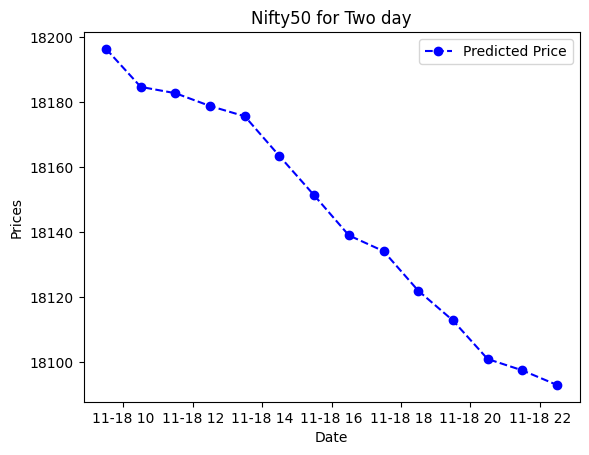

In [36]:
plt.plot(future_index, output, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.title('Nifty50 for Two day')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()